## Double-Well SDE and PriorVAE

In [1]:
import random as rnd

import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import optax

from priorCVAE.priors import DoubleWellSDE
from priorCVAE.datasets import SDEDataset
from priorCVAE.models import MLPDecoder, MLPEncoder, VAE
from priorCVAE.trainer import VAETrainer

## Configuration

In [2]:
args = {
        # setup
        "t0" : 0,
        "t1" : 20,
        "dt" : 0.01,
        
        # architecture
        "input_dim" : None,  # This is set later depending on the time-grid
        "hidden_dim": 100,
        "latent_dim": 50,
        
        # VAE training    
        "batch_size": 2000,
        "num_iterations": 8000,
        "learning_rate": 1e-3,
       }

## Simulate the SDE and generate data

In [3]:
base_sde = DoubleWellSDE(c=2, q=3)
x_init = jnp.ones((1, 1))

sde_dataset_generator = SDEDataset(base_sde, x_init, dt=args["dt"], t_lim_high=args["t1"], t_lim_low=args["t0"]) 

In [4]:
sample_t_train, sample_y_train, _ = sde_dataset_generator.simulatedata(n_samples=100)
t_test, y_test, _ = sde_dataset_generator.simulatedata(n_samples=100)

In [5]:
args["input_dim"] = sample_y_train.shape[1]

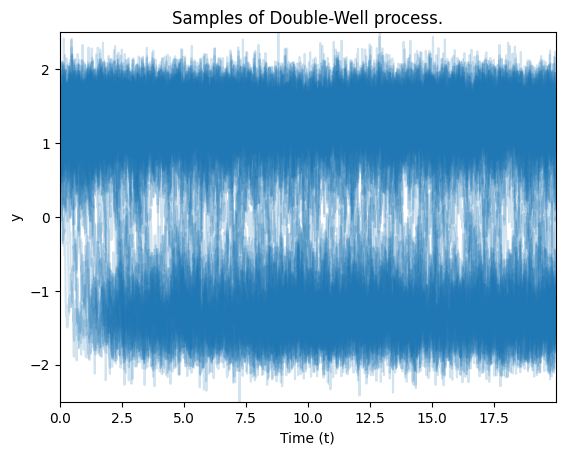

In [6]:
for y_i in sample_y_train:
    plt.plot(sample_t_train[0], y_i, color="tab:blue", alpha=0.2)

plt.xlim([sample_t_train[0][0], sample_t_train[0][-1]])
plt.ylim([-2.5, 2.5])
plt.title("Samples of Double-Well process.")
plt.xlabel("Time (t)")
plt.ylabel("y")
plt.show()

## PriorVAE model

In [7]:
out_dim     = args["input_dim"]
hidden_dim  = args["hidden_dim"]
latent_dim  = args["latent_dim"]
batch_size  = args["batch_size"]
num_iterations  = args["num_iterations"]
learning_rate = args["learning_rate"]

In [8]:
encoder = MLPEncoder(hidden_dim, latent_dim)
decoder = MLPDecoder(hidden_dim, out_dim)
model = VAE(encoder, decoder)

optimizer = optax.adam(learning_rate=learning_rate)

## Train the model

In [9]:
trainer = VAETrainer(model, optimizer)
trainer.init_params(sample_y_train[0])

test_set = (t_test, y_test, _)
loss_vals, test_vals, time_taken = trainer.train(sde_dataset_generator, test_set, num_iterations)

print(f'Training of {num_iterations} iterations took {round(time_taken)} seconds')


[    1] training loss: 199842.688, test loss: 172717.359
[   11] training loss: 159299.500, test loss: 159147.031
[   21] training loss: 148030.891, test loss: 151876.672
[   31] training loss: 121290.047, test loss: 121785.430
[   41] training loss: 109441.273, test loss: 107075.477
[   51] training loss: 104589.172, test loss: 100355.727
[   61] training loss: 80708.375, test loss: 88644.773
[   71] training loss: 75773.305, test loss: 85773.695
[   81] training loss: 77497.375, test loss: 82788.586
[   91] training loss: 67376.758, test loss: 78462.555
[  101] training loss: 63336.691, test loss: 71950.070
[  111] training loss: 62376.137, test loss: 69240.102
[  121] training loss: 57019.051, test loss: 67279.125
[  131] training loss: 56448.234, test loss: 67540.328
[  141] training loss: 62050.051, test loss: 66735.117
[  151] training loss: 62661.867, test loss: 67330.500
[  161] training loss: 59772.652, test loss: 66264.734
[  171] training loss: 56680.512, test loss: 65041.43

[ 1491] training loss: 28545.086, test loss: 26972.250
[ 1501] training loss: 27350.660, test loss: 26733.016
[ 1511] training loss: 27296.623, test loss: 26757.244
[ 1521] training loss: 25201.045, test loss: 26617.096
[ 1531] training loss: 26665.094, test loss: 26641.223
[ 1541] training loss: 25909.039, test loss: 26724.580
[ 1551] training loss: 26217.453, test loss: 26608.904
[ 1561] training loss: 26336.105, test loss: 26382.994
[ 1571] training loss: 26258.256, test loss: 26455.877
[ 1581] training loss: 26049.195, test loss: 26474.006
[ 1591] training loss: 27110.936, test loss: 26346.793
[ 1601] training loss: 25856.070, test loss: 26596.420
[ 1611] training loss: 26686.596, test loss: 26572.244
[ 1621] training loss: 24348.402, test loss: 26364.137
[ 1631] training loss: 26813.875, test loss: 26346.609
[ 1641] training loss: 26813.896, test loss: 26451.059
[ 1651] training loss: 26090.492, test loss: 26177.773
[ 1661] training loss: 26246.328, test loss: 26367.254
[ 1671] tr

[ 2981] training loss: 21677.875, test loss: 22521.121
[ 2991] training loss: 22137.246, test loss: 22620.754
[ 3001] training loss: 22737.395, test loss: 22695.609
[ 3011] training loss: 22087.158, test loss: 22697.029
[ 3021] training loss: 22410.477, test loss: 22755.947
[ 3031] training loss: 22441.129, test loss: 22599.316
[ 3041] training loss: 22836.979, test loss: 22521.807
[ 3051] training loss: 22301.441, test loss: 22686.354
[ 3061] training loss: 21846.672, test loss: 22563.932
[ 3071] training loss: 22479.252, test loss: 22350.537
[ 3081] training loss: 22480.438, test loss: 22637.133
[ 3091] training loss: 22720.836, test loss: 22523.168
[ 3101] training loss: 22286.965, test loss: 22452.586
[ 3111] training loss: 23263.486, test loss: 22454.059
[ 3121] training loss: 22903.238, test loss: 22611.609
[ 3131] training loss: 21985.484, test loss: 22363.012
[ 3141] training loss: 22424.529, test loss: 22340.359
[ 3151] training loss: 22764.982, test loss: 22624.398
[ 3161] tr

[ 4471] training loss: 21359.189, test loss: 21020.400
[ 4481] training loss: 20613.420, test loss: 21115.936
[ 4491] training loss: 20725.684, test loss: 20998.740
[ 4501] training loss: 20616.979, test loss: 21386.006
[ 4511] training loss: 20555.012, test loss: 21195.270
[ 4521] training loss: 20711.303, test loss: 21066.756
[ 4531] training loss: 21282.949, test loss: 21058.855
[ 4541] training loss: 20121.287, test loss: 21134.373
[ 4551] training loss: 20443.447, test loss: 21321.957
[ 4561] training loss: 21442.066, test loss: 21084.582
[ 4571] training loss: 20346.852, test loss: 21056.117
[ 4581] training loss: 20540.275, test loss: 20938.502
[ 4591] training loss: 21184.818, test loss: 20983.363
[ 4601] training loss: 21292.037, test loss: 21059.453
[ 4611] training loss: 20864.275, test loss: 21045.094
[ 4621] training loss: 19739.949, test loss: 21006.000
[ 4631] training loss: 21214.482, test loss: 20858.887
[ 4641] training loss: 21078.807, test loss: 21141.889
[ 4651] tr

[ 5961] training loss: 20271.424, test loss: 20068.840
[ 5971] training loss: 19136.223, test loss: 20268.402
[ 5981] training loss: 19500.797, test loss: 20085.066
[ 5991] training loss: 19862.219, test loss: 20172.191
[ 6001] training loss: 19723.348, test loss: 20027.297
[ 6011] training loss: 20252.879, test loss: 20096.385
[ 6021] training loss: 19709.154, test loss: 20236.646
[ 6031] training loss: 20532.148, test loss: 20069.621
[ 6041] training loss: 19407.703, test loss: 20044.502
[ 6051] training loss: 19130.164, test loss: 19981.043
[ 6061] training loss: 19952.283, test loss: 20068.676
[ 6071] training loss: 19444.000, test loss: 20175.455
[ 6081] training loss: 19877.408, test loss: 20117.152
[ 6091] training loss: 20101.160, test loss: 20059.420
[ 6101] training loss: 19539.740, test loss: 20319.270
[ 6111] training loss: 20450.770, test loss: 20129.531
[ 6121] training loss: 19401.646, test loss: 20332.512
[ 6131] training loss: 19549.010, test loss: 20125.203
[ 6141] tr

[ 7451] training loss: 19349.711, test loss: 19408.592
[ 7461] training loss: 19029.010, test loss: 19459.018
[ 7471] training loss: 19693.676, test loss: 19253.496
[ 7481] training loss: 19072.371, test loss: 19279.020
[ 7491] training loss: 19624.680, test loss: 19477.424
[ 7501] training loss: 18934.496, test loss: 19414.484
[ 7511] training loss: 18866.998, test loss: 19494.963
[ 7521] training loss: 19000.367, test loss: 19365.609
[ 7531] training loss: 19418.711, test loss: 19346.334
[ 7541] training loss: 18854.586, test loss: 19474.182
[ 7551] training loss: 19240.432, test loss: 19406.781
[ 7561] training loss: 18822.430, test loss: 19419.197
[ 7571] training loss: 18892.301, test loss: 19421.838
[ 7581] training loss: 19238.389, test loss: 19483.020
[ 7591] training loss: 19007.383, test loss: 19404.598
[ 7601] training loss: 19418.721, test loss: 19349.145
[ 7611] training loss: 19255.889, test loss: 19243.434
[ 7621] training loss: 19184.154, test loss: 19276.635
[ 7631] tr

In [12]:
loss_vals, test_vals, time_taken = trainer.train(sde_dataset_generator, test_set, num_iterations)

[    1] training loss: 19431.775, test loss: 19286.133
[   11] training loss: 19397.285, test loss: 19296.408
[   21] training loss: 18771.400, test loss: 19405.674
[   31] training loss: 18543.619, test loss: 19298.908
[   41] training loss: 19169.404, test loss: 19331.738
[   51] training loss: 19494.824, test loss: 19379.906
[   61] training loss: 20119.193, test loss: 19236.660
[   71] training loss: 19419.973, test loss: 19262.633
[   81] training loss: 19134.834, test loss: 19359.695
[   91] training loss: 18545.393, test loss: 19329.297
[  101] training loss: 19135.391, test loss: 19325.855
[  111] training loss: 19143.201, test loss: 19226.660
[  121] training loss: 18950.449, test loss: 19504.375
[  131] training loss: 19361.398, test loss: 19363.291
[  141] training loss: 19764.814, test loss: 19165.707
[  151] training loss: 18744.691, test loss: 19391.248
[  161] training loss: 18967.846, test loss: 19344.812
[  171] training loss: 19970.459, test loss: 19312.652
[  181] tr

[ 1491] training loss: 19392.713, test loss: 19051.367
[ 1501] training loss: 18995.918, test loss: 19059.068
[ 1511] training loss: 19295.650, test loss: 19145.328
[ 1521] training loss: 18559.277, test loss: 19088.553
[ 1531] training loss: 18942.646, test loss: 18972.766
[ 1541] training loss: 18553.314, test loss: 19041.303
[ 1551] training loss: 19181.561, test loss: 19357.240
[ 1561] training loss: 18930.939, test loss: 19064.260
[ 1571] training loss: 18714.988, test loss: 19011.203
[ 1581] training loss: 18377.633, test loss: 19162.523
[ 1591] training loss: 18537.668, test loss: 19109.654
[ 1601] training loss: 19280.715, test loss: 19010.406
[ 1611] training loss: 18619.582, test loss: 19212.666
[ 1621] training loss: 18951.236, test loss: 19031.961
[ 1631] training loss: 18534.750, test loss: 18883.145
[ 1641] training loss: 18258.648, test loss: 18980.668
[ 1651] training loss: 18788.381, test loss: 19144.355
[ 1661] training loss: 19040.412, test loss: 19114.287
[ 1671] tr

[ 2981] training loss: 18804.674, test loss: 18794.855
[ 2991] training loss: 18914.145, test loss: 18712.666
[ 3001] training loss: 18714.709, test loss: 18655.840
[ 3011] training loss: 18101.443, test loss: 18889.619
[ 3021] training loss: 18709.684, test loss: 18920.543
[ 3031] training loss: 18706.557, test loss: 18775.895
[ 3041] training loss: 18816.951, test loss: 19028.004
[ 3051] training loss: 18157.576, test loss: 18878.605
[ 3061] training loss: 18329.264, test loss: 18903.697
[ 3071] training loss: 18592.904, test loss: 18755.682
[ 3081] training loss: 18447.711, test loss: 18845.580
[ 3091] training loss: 18908.672, test loss: 18940.451
[ 3101] training loss: 18289.215, test loss: 18711.047
[ 3111] training loss: 18886.715, test loss: 18803.838
[ 3121] training loss: 18605.703, test loss: 18530.801
[ 3131] training loss: 18564.305, test loss: 18746.691
[ 3141] training loss: 18924.258, test loss: 18633.627
[ 3151] training loss: 18948.037, test loss: 18626.881
[ 3161] tr

[ 4471] training loss: 18221.688, test loss: 18475.369
[ 4481] training loss: 18087.043, test loss: 18432.520
[ 4491] training loss: 18462.047, test loss: 18483.098
[ 4501] training loss: 18767.590, test loss: 18725.271
[ 4511] training loss: 18449.297, test loss: 18571.002
[ 4521] training loss: 18354.875, test loss: 18672.309
[ 4531] training loss: 18629.359, test loss: 18658.508
[ 4541] training loss: 18755.414, test loss: 18450.930
[ 4551] training loss: 18327.895, test loss: 18555.400
[ 4561] training loss: 18453.264, test loss: 18566.025
[ 4571] training loss: 18235.020, test loss: 18415.418
[ 4581] training loss: 17976.064, test loss: 18427.023
[ 4591] training loss: 19123.984, test loss: 18455.818
[ 4601] training loss: 18333.428, test loss: 18552.219
[ 4611] training loss: 18238.898, test loss: 18478.434
[ 4621] training loss: 18812.094, test loss: 18441.152
[ 4631] training loss: 18122.496, test loss: 18430.693
[ 4641] training loss: 18222.443, test loss: 18655.625
[ 4651] tr

[ 5961] training loss: 17918.711, test loss: 18192.254
[ 5971] training loss: 18275.885, test loss: 18435.271
[ 5981] training loss: 18593.740, test loss: 18542.160
[ 5991] training loss: 18182.551, test loss: 18432.504
[ 6001] training loss: 18085.781, test loss: 18167.662
[ 6011] training loss: 19034.527, test loss: 18250.008
[ 6021] training loss: 17903.244, test loss: 18407.852
[ 6031] training loss: 18129.406, test loss: 18240.992
[ 6041] training loss: 18561.314, test loss: 18388.633
[ 6051] training loss: 17789.691, test loss: 18308.889
[ 6061] training loss: 18410.584, test loss: 18381.146
[ 6071] training loss: 18763.484, test loss: 18376.820
[ 6081] training loss: 18220.061, test loss: 18332.559
[ 6091] training loss: 18122.098, test loss: 18229.309
[ 6101] training loss: 18073.133, test loss: 18505.547
[ 6111] training loss: 17997.391, test loss: 18315.434
[ 6121] training loss: 17926.293, test loss: 18357.785
[ 6131] training loss: 18213.480, test loss: 18459.889
[ 6141] tr

[ 7451] training loss: 18217.227, test loss: 18247.412
[ 7461] training loss: 17585.975, test loss: 18310.311
[ 7471] training loss: 18430.840, test loss: 18071.363
[ 7481] training loss: 18333.010, test loss: 18103.590
[ 7491] training loss: 18726.664, test loss: 18309.906
[ 7501] training loss: 18242.006, test loss: 18335.127
[ 7511] training loss: 18548.016, test loss: 18468.244
[ 7521] training loss: 18644.199, test loss: 18365.275
[ 7531] training loss: 18108.891, test loss: 18161.324
[ 7541] training loss: 18283.697, test loss: 18285.188
[ 7551] training loss: 17796.568, test loss: 18281.324
[ 7561] training loss: 17904.803, test loss: 18199.586
[ 7571] training loss: 18630.113, test loss: 18188.434
[ 7581] training loss: 18102.242, test loss: 18154.449
[ 7591] training loss: 18261.578, test loss: 18118.941
[ 7601] training loss: 17569.537, test loss: 18188.006
[ 7611] training loss: 18064.072, test loss: 18329.959
[ 7621] training loss: 18150.344, test loss: 18431.172
[ 7631] tr

Text(0.5, 1.0, 'Test loss')

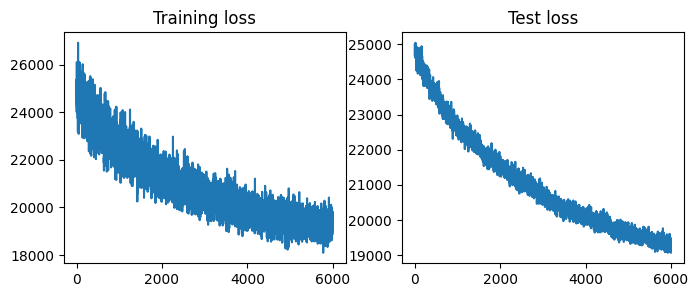

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

skip_initial = 2000

axs[0].plot(range(len(loss_vals) - skip_initial), loss_vals[skip_initial:])
axs[0].set_title('Training loss')

axs[1].plot(range(len(test_vals) - skip_initial), test_vals[skip_initial:])
axs[1].set_title("Test loss")


## Samples from trained decoder

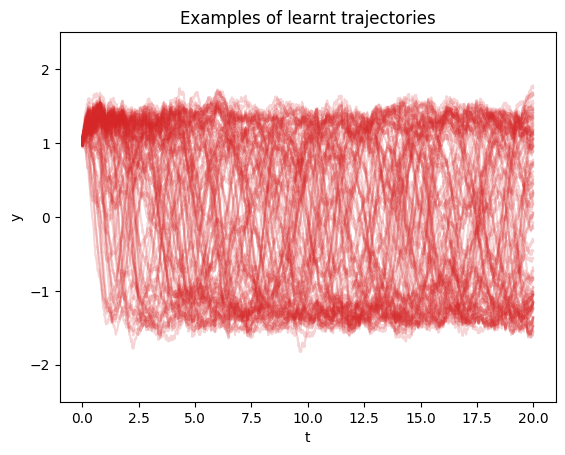

In [15]:
decoder_params = trainer.state.params['decoder']

key = jax.random.PRNGKey(rnd.randint(0, 9999))
rng, z_rng, init_rng = jax.random.split(key, 3)
z = jax.random.normal(z_rng, (batch_size, latent_dim))

decoder = MLPDecoder(hidden_dim, out_dim)
out = decoder.apply({'params': decoder_params}, z)             

for i in range(100):
    plt.plot(sample_t_train[0], out[i,:], color="tab:red", alpha=0.2)

# for y_i in sample_y_train:
#     plt.plot(sample_t_train[0], y_i, color="tab:blue", alpha=0.1)

plt.xlabel('t')
plt.ylabel('y')
plt.ylim([-2.5, 2.5])
plt.title('Examples of learnt trajectories')

plt.show()